In [103]:
import glob
import sys
import os

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, accuracy_score

In [104]:
sys.path.append(os.path.abspath('../src'))

from read_and_write_docs import read_jsonl, write_jsonl, read_rds
from performance import performance, performance_paraphrase

In [105]:
v1_dir = "/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v1/Wiki-training"
v2_dir = "/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v2/Wiki-training"

In [111]:
def plot_distributions(df):
    # Plot histogram of scores by target
    plt.figure()
    df[df['target'] == True]['score'].hist(alpha=0.7, label='Same Author')
    df[df['target'] == False]['score'].hist(alpha=0.7, label='Different Authors')
    plt.title('Score Distribution by True/False Author Match')
    plt.xlabel('Log Likelihood Ratio Score')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [146]:
def plot_roc(df):
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(grouped_data['target'], grouped_data['score'])
    roc_auc = auc(fpr, tpr)
    
    # Determine best threshold (Youden's J statistic)
    youden_j = tpr - fpr
    best_idx = youden_j.argmax()
    best_threshold = thresholds[best_idx]
    
    # Compute metrics at best threshold
    preds = grouped_data['score'] >= best_threshold
    f1 = f1_score(grouped_data['target'], preds)
    accuracy = accuracy_score(grouped_data['target'], preds)
    cm = confusion_matrix(grouped_data['target'], preds)
    cm_df = pd.DataFrame(cm, index=['Actual False', 'Actual True'], columns=['Predicted False', 'Predicted True'])
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.scatter(fpr[best_idx], tpr[best_idx], marker='o', label=f'Best Threshold = {best_threshold:.1f}')
    plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Display metrics and confusion matrix
    print("\nSummary Metrics\n")
    print(f"Optimal Threshold (Youden's J): {best_threshold:.3f}")
    print(f"AUC: {roc_auc:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"Accuracy: {accuracy:.3f}")

    print("\nConfustion Matrix")
    print(cm_df)

# Paraphrase V1

In [152]:
v1_jsonl_files = glob.glob(f"{v1_dir}/*.jsonl")
sorted(v1_jsonl_files)

print(v1_jsonl_files)

['/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v1/Wiki-training/gen_t_1.0.jsonl', '/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v1/Wiki-training/gen_t_0.7.jsonl', '/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v1/Wiki-training/gen_t_1.2.jsonl']


In [153]:
data = read_jsonl(v1_jsonl_files[2])

grouped_data = (
    data
    .groupby(['problem', 'target'], as_index=False)
    ['score']
    .mean()
)

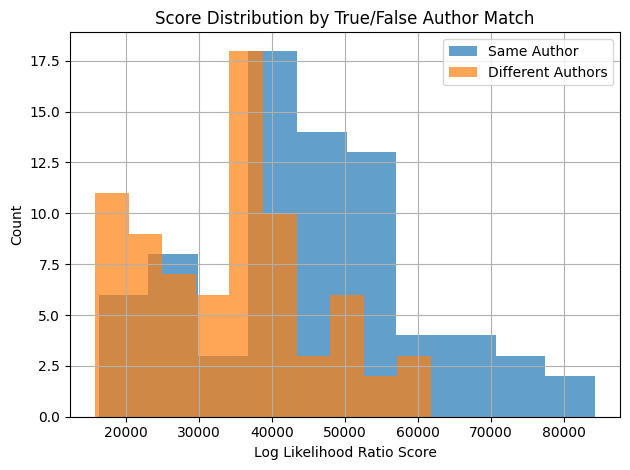

In [154]:
plot_distributions(grouped_data)

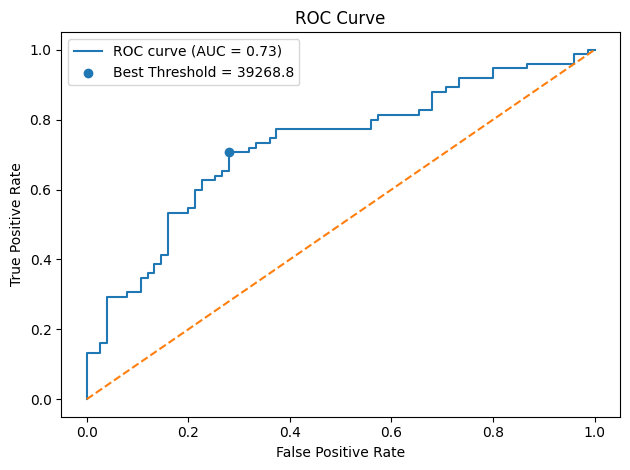


Summary Metrics

Optimal Threshold (Youden's J): 39268.806
AUC: 0.727
F1 Score: 0.711
Accuracy: 0.713

Confustion Matrix
              Predicted False  Predicted True
Actual False               54              21
Actual True                22              53


In [155]:
plot_roc(grouped_data)

In [156]:
score_col = 'score'
target_col = 'target'
performance(grouped_data,
            score_col,
            target_col,
            additional_metadata={
                'corpus': "Wiki-training"
            })

,corpus,Cllr,Cllr_min,EER,Mean_TRUE_LLR,Mean_FALSE_LLR,TRUE_trials,FALSE_trials,AUC,Balanced_Accuracy,Precision,Recall,F1,TP,FP,FN,TN
0,Wiki-training,0.904344,0.904344,0.32,0.145668,-0.132396,75,75,0.712711,0.706667,0.712329,0.693333,0.702703,52,21,23,54


# Paraphrase V2

Paraphrase v2 is the LambdaG code in its traditional form where we lump all of the paraphrased sentences together and randomly sample them for the same number as in the known document.

Accidentally kept the r at 100

In [93]:
jsonl_files = glob.glob(f"{v2_dir}/*.jsonl")
sorted(jsonl_files)

print(jsonl_files)

['/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v2/Wiki-training/gen_t_0.7.jsonl', '/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v2/Wiki-training/gen_t_1.5.jsonl', '/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v2/Wiki-training/sim_t_0.7.jsonl', '/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v2/Wiki-training/sim_t_1.0.jsonl', '/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v2/Wiki-training/sim_t_1.2.jsonl', '/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v2/Wiki-training/sim_t_1.5.jsonl', '/Volumes/BCross/datasets/author_verification/lambda_g_results/paraphrase_v2/Wiki-training/gen_t_1.2.jsonl']


In [94]:
data = read_jsonl(jsonl_files[-1])

In [168]:
data = read_jsonl('/Volumes/BCross/datasets/author_verification/training/Wiki/Qwen_2.5_1.5B/gen_t_1.5_tp_0.9/lambda_g_results.jsonl')
data = read_jsonl('/Volumes/BCross/datasets/author_verification/lambda_g_results/Wiki_training_qwen2.5_1.5b_instruct_max_sim.jsonl')
data = read_jsonl('/Volumes/BCross/datasets/author_verification/lambda_g_results/Wiki_training_qwen2.5_1.5b_instruct_raw.jsonl')

In [169]:
grouped_data = (
    data
    .groupby(['problem', 'target'], as_index=False)
    ['score']
    .mean()
)

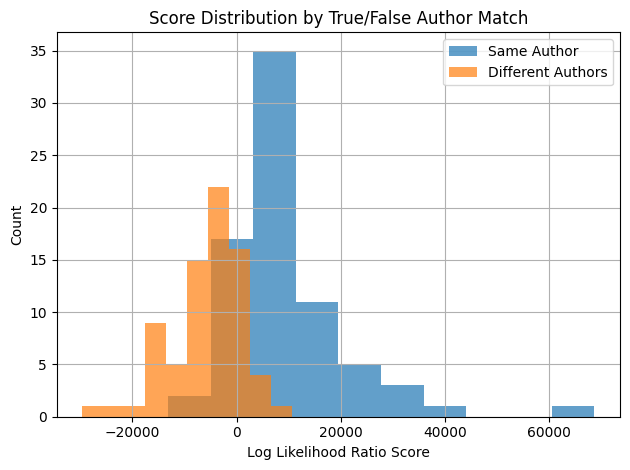

In [170]:
plot_distributions(grouped_data)

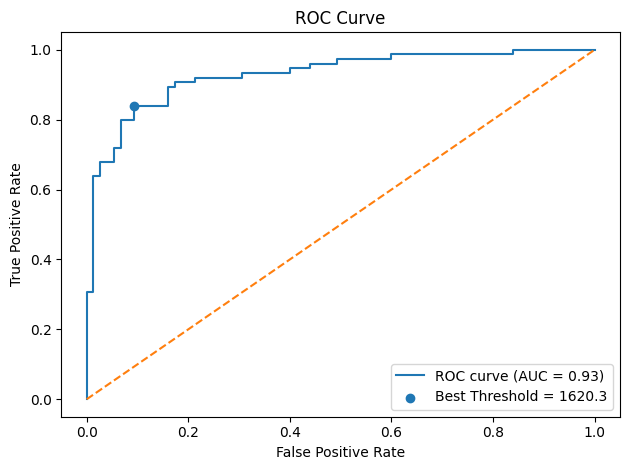


Summary Metrics

Optimal Threshold (Youden's J): 1620.330
AUC: 0.929
F1 Score: 0.869
Accuracy: 0.873

Confustion Matrix
              Predicted False  Predicted True
Actual False               68               7
Actual True                12              63


In [171]:
plot_roc(grouped_data)

In [172]:
score_col = 'score'
target_col = 'target'
performance(grouped_data,
            score_col,
            target_col,
            additional_metadata={
                'corpus': "Wiki-training"
            })

,corpus,Cllr,Cllr_min,EER,Mean_TRUE_LLR,Mean_FALSE_LLR,TRUE_trials,FALSE_trials,AUC,Balanced_Accuracy,Precision,Recall,F1,TP,FP,FN,TN
0,Wiki-training,0.526181,0.526181,0.16,1.262601,-0.993469,75,75,0.923022,0.84,0.84,0.84,0.84,63,12,12,63


In [165]:
score_col = 'score'
target_col = 'target'
performance_paraphrase(grouped_data,
            score_col,
            target_col,
            additional_metadata={
                'corpus': "Wiki-training"
            })

,corpus,Cllr,Cllr_min,EER,Mean_TRUE_LLR,Mean_FALSE_LLR,TRUE_trials,FALSE_trials,AUC,Balanced_Accuracy,Precision,Recall,F1,TP,FP,FN,TN
0,Wiki-training,0.574403,0.574403,0.16,1.091857,-0.825178,75,75,0.903822,0.806667,0.802632,0.813333,0.807947,61,15,14,60
